In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-dataset/flo_data.csv


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime as dt

In [3]:
df=pd.read_csv("/kaggle/input/flo-dataset/flo_data.csv")
warnings.simplefilter(action='ignore', category=Warning)

In [4]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    #print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [5]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

In [6]:
df=df.drop(columns="master_id")

In [7]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 19945
Variables: 11
cat_cols: 2
num_cols: 4
cat_but_car: 5
num_but_cat: 0
['order_channel', 'last_order_channel']
['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online']
['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'interested_in_categories_12']


In [9]:
for col in cat_cols:
    cat_summary(df, col)

               order_channel      Ratio
order_channel                          
Android App             9495  47.605916
Mobile                  4882  24.477313
Ios App                 2833  14.204061
Desktop                 2735  13.712710
##########################################
                    last_order_channel      Ratio
last_order_channel                               
Android App                       6783  34.008523
Offline                           6608  33.131111
Mobile                            3172  15.903735
Ios App                           1696   8.503384
Desktop                           1686   8.453246
##########################################


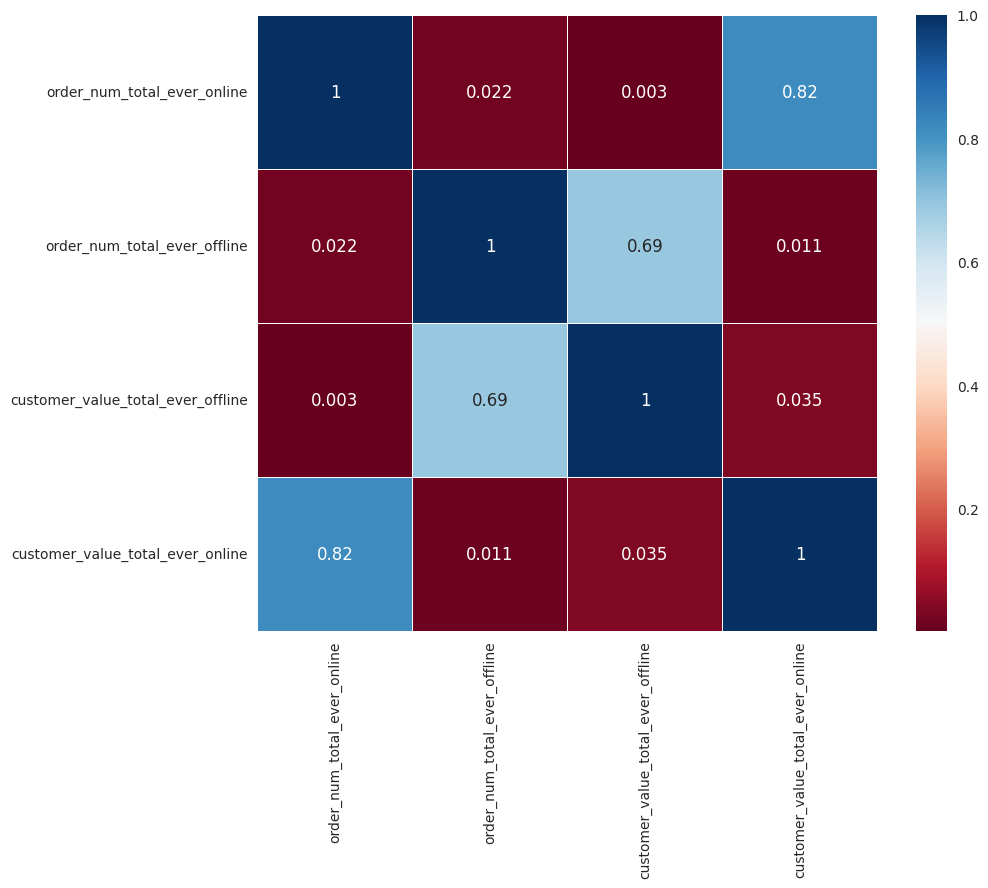

In [10]:
correlation_matrix(df,num_cols)


In [11]:
for i in df.columns:
    if "date" in i:
        df[i]=pd.to_datetime(df[i])


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_channel                      19945 non-null  object        
 1   last_order_channel                 19945 non-null  object        
 2   first_order_date                   19945 non-null  datetime64[ns]
 3   last_order_date                    19945 non-null  datetime64[ns]
 4   last_order_date_online             19945 non-null  datetime64[ns]
 5   last_order_date_offline            19945 non-null  datetime64[ns]
 6   order_num_total_ever_online        19945 non-null  float64       
 7   order_num_total_ever_offline       19945 non-null  float64       
 8   customer_value_total_ever_offline  19945 non-null  float64       
 9   customer_value_total_ever_online   19945 non-null  float64       
 10  interested_in_categories_12       

In [12]:
print(df["last_order_date"].max())
today_date=dt.datetime(2021,6,1)

2021-05-30 00:00:00


In [13]:
df["Tenure"]=(today_date-df["first_order_date"]).dt.days # Müşterinin Yaşı
df["ShoppingDays"]=(today_date-df["last_order_date"]).dt.days # Kaç gün önce alışveriş yapmış.

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print("Cat_cols",cat_cols)
print("Num_Cols",num_cols)
print("Car_Cols",cat_but_car)

Observations: 19945
Variables: 13
cat_cols: 2
num_cols: 10
cat_but_car: 1
num_but_cat: 0
Cat_cols ['order_channel', 'last_order_channel']
Num_Cols ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'Tenure', 'ShoppingDays']
Car_Cols ['interested_in_categories_12']


In [15]:
df.head()

,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Tenure,ShoppingDays
0,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],214,95
1,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",1574,105
2,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",552,186
3,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",146,135
4,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],668,86


**Aykırı Değer Analizi**

In [16]:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [17]:
for col in num_cols:
    print(col, check_outlier(df, col))

first_order_date True
last_order_date False
last_order_date_online True
last_order_date_offline False
order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True
Tenure True
ShoppingDays False


In [18]:
for col in num_cols:
    replace_with_thresholds(df,col)
    

In [19]:

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


In [20]:
df=one_hot_encoder(df,cat_cols,drop_first=True)


In [21]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 19945
Variables: 18
cat_cols: 8
num_cols: 9
cat_but_car: 1
num_but_cat: 8
['order_num_total_ever_offline', 'order_channel_Desktop', 'order_channel_Ios App', 'order_channel_Mobile', 'last_order_channel_Desktop', 'last_order_channel_Ios App', 'last_order_channel_Mobile', 'last_order_channel_Offline']
['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'Tenure', 'ShoppingDays']
['interested_in_categories_12']


In [22]:
for i in cat_cols:
    df[i]=df[i].astype("int")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   first_order_date                   19945 non-null  datetime64[ns]
 1   last_order_date                    19945 non-null  datetime64[ns]
 2   last_order_date_online             19945 non-null  datetime64[ns]
 3   last_order_date_offline            19945 non-null  datetime64[ns]
 4   order_num_total_ever_online        19945 non-null  float64       
 5   order_num_total_ever_offline       19945 non-null  int64         
 6   customer_value_total_ever_offline  19945 non-null  float64       
 7   customer_value_total_ever_online   19945 non-null  float64       
 8   interested_in_categories_12        19945 non-null  object        
 9   Tenure                             19945 non-null  float64       
 10  ShoppingDays                      

In [24]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
ss=StandardScaler().fit_transform(df[numeric_cols])

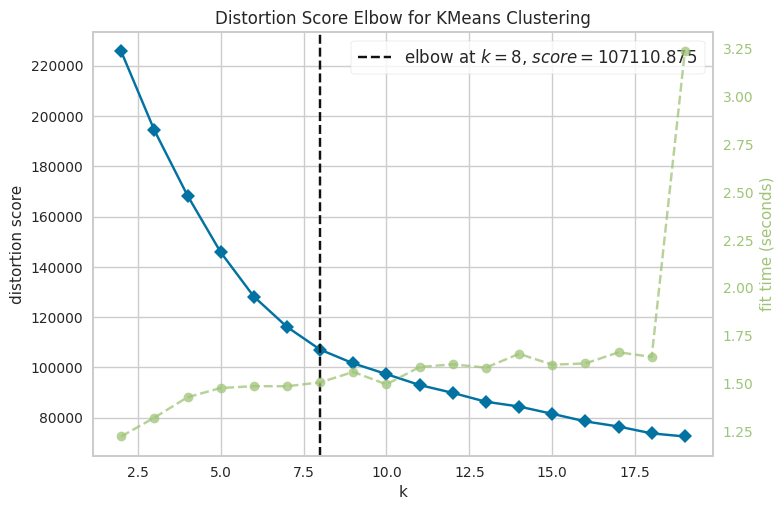

8

In [25]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(ss)
elbow.show()

elbow.elbow_value_


In [26]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(ss)

kmeans.n_clusters
kmeans.cluster_centers_
kmeans.labels_
df[0:5]

clusters_kmeans = kmeans.labels_

In [27]:

df["cluster"] = clusters_kmeans
df["cluster"] = df["cluster"] + 1

df.head()

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Tenure,ShoppingDays,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline,cluster
0,2020-10-30 00:00:00,2021-02-26,2021-02-21,2021-02-26,4.0,1,139.99,799.38,[KADIN],214.0,95.0,0,0,0,0,0,0,1,2
1,2017-10-25 12:00:00,2021-02-16,2021-02-16,2020-01-10,8.5,2,159.97,1221.13,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",1314.5,105.0,0,0,0,0,0,1,0,3
2,2019-11-27 00:00:00,2020-11-27,2020-11-27,2019-12-01,3.0,2,189.97,395.35,"[ERKEK, KADIN]",552.0,186.0,0,0,0,0,0,0,0,1
3,2021-01-06 00:00:00,2021-01-17,2021-01-17,2021-01-06,1.0,1,39.99,81.98,"[AKTIFCOCUK, COCUK]",146.0,135.0,0,0,0,0,0,0,0,1
4,2019-08-03 00:00:00,2021-03-07,2021-03-07,2019-08-03,1.0,1,49.99,159.99,[AKTIFSPOR],668.0,86.0,1,0,0,1,0,0,0,8


In [28]:
df.groupby("cluster")[numeric_cols].agg(["count","mean","median"])

order_num_total_ever_online                   \
                              count      mean median   
cluster                                                
1                              4359  2.089011    2.0   
2                              2981  1.699430    1.0   
3                              2466  7.221614    8.0   
4                              2830  1.967491    1.0   
5                              1696  2.931014    2.0   
6                              2583  2.115950    2.0   
7                              1521  1.640368    1.0   
8                              1509  2.500000    2.0   

        order_num_total_ever_offline                   \
                               count      mean median   
cluster                                                 
1                               4359  1.289745    1.0   
2                               2981  1.415968    1.0   
3                               2466  1.699919    1.0   
4                               2830  1.474558    1.0   
5                               1696  1.524175    1.0   
6                               2583  2.850949    3.0   
7                               1521  1.837607    2.0   
8                               1509  1.509609    1.0   

        customer_value_total_ever_offline                       \
                                    count        mean   median   
cluster                                                          
1                                    4359  149.334646  122.980   
2                                    2981  184.210939  164.980   
3                                    2466  220.274680  170.455   
4                                    2830  191.473314  142.350   
5                                    1696  211.711156  159.990   
6                                    2583  484.818091  490.470   
7                                    1521  282.323531  239.990   
8                                    1509  205.609476  150.730   

        customer_value_total_ever_online  ... last_order_channel_Desktop  \
                                   count  ...                     median   
cluster                                   ...                              
1                                   4359  ...                        0.0   
2                                   2981  ...                        0.0   
3                                   2466  ...                        0.0   
4                                   2830  ...                        0.0   
5                                   1696  ...                        0.0   
6                                   2583  ...                        0.0   
7                                   1521  ...                        0.0   
8                                   1509  ...                        1.0   

        last_order_channel_Ios App             last_order_channel_Mobile  \
                             count mean median                     count   
cluster                                                                    
1                             4359  0.0    0.0                      4359   
2                             2981  0.0    0.0                      2981   
3                             2466  0.0    0.0                      2466   
4                             2830  0.0    0.0                      2830   
5                             1696  1.0    1.0                      1696   
6                             2583  0.0    0.0                      2583   
7                             1521  0.0    0.0                      1521   
8                             1509  0.0    0.0                      1509   

                         last_order_channel_Offline                   
             mean median                      count      mean median  
cluster                                                               
1        0.000000    0.0                       4359  0.000000    0.0  
2        0.000000    0.0                       2981  1.000000    1.0  
3      

**Hierarchical Clustering**

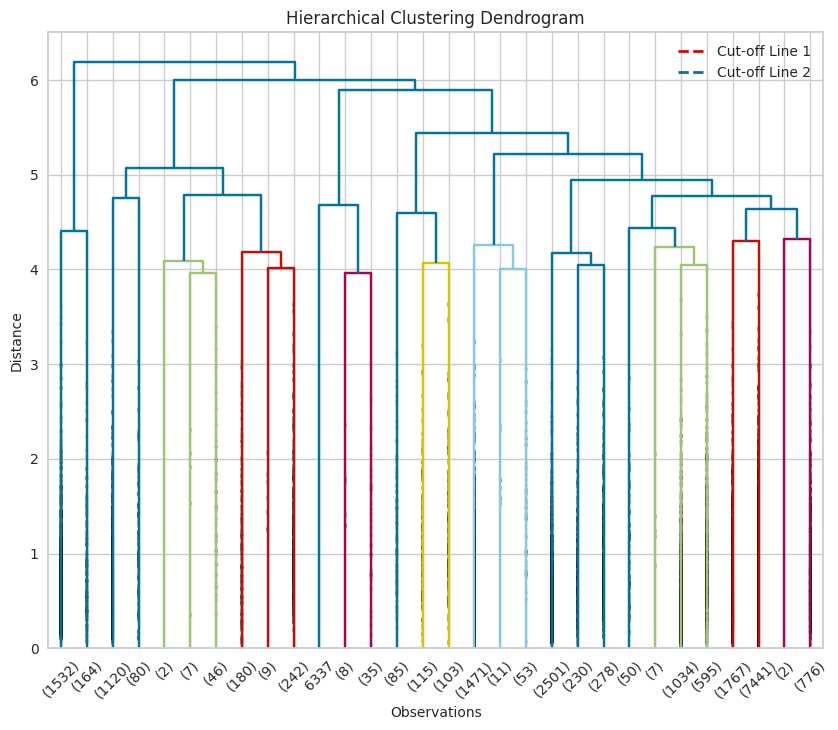

In [29]:
hc_average = linkage(ss, "average") ##linkage -- birleştirici yöntemdir.
plt.figure(figsize=(10, 8))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=30,
           show_contracted=True,
           leaf_font_size=10)

plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.xlabel('Observations', fontsize=10)
plt.ylabel('Distance', fontsize=10)

# Adding cut-off lines
plt.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Cut-off Line 1')
plt.axhline(y=180, color='b', linestyle='--', linewidth=2, label='Cut-off Line 2')

# Displaying the legend
plt.legend(loc='upper right')
plt.show();

In [30]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, linkage="average")

clusters = cluster.fit_predict(ss)

In [31]:
df["hi_cluster_no"] = clusters

df["hi_cluster_no"] = df["hi_cluster_no"] + 1

In [32]:
df.head()

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Tenure,ShoppingDays,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline,cluster,hi_cluster_no
0,2020-10-30 00:00:00,2021-02-26,2021-02-21,2021-02-26,4.0,1,139.99,799.38,[KADIN],214.0,95.0,0,0,0,0,0,0,1,2,1
1,2017-10-25 12:00:00,2021-02-16,2021-02-16,2020-01-10,8.5,2,159.97,1221.13,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",1314.5,105.0,0,0,0,0,0,1,0,3,1
2,2019-11-27 00:00:00,2020-11-27,2020-11-27,2019-12-01,3.0,2,189.97,395.35,"[ERKEK, KADIN]",552.0,186.0,0,0,0,0,0,0,0,1,1
3,2021-01-06 00:00:00,2021-01-17,2021-01-17,2021-01-06,1.0,1,39.99,81.98,"[AKTIFCOCUK, COCUK]",146.0,135.0,0,0,0,0,0,0,0,1,1
4,2019-08-03 00:00:00,2021-03-07,2021-03-07,2019-08-03,1.0,1,49.99,159.99,[AKTIFSPOR],668.0,86.0,1,0,0,1,0,0,0,8,3
